In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def get_sentences(data_list):
    sentences = []
    for a in data_list.article.unique():
        words = []
        prev_n = 0
        for _,s in data_list.loc[data_list.article == a].iterrows():
            n = s['sentence_no']
            if n != prev_n:
                if len(words) > 2 and len(set([x[1] for x in words])) > 1:
                    sentences.append(words)
                words = []
            words.append((s['word'], s['encoding'], s['part_of_speech']))
            prev_n = n
            
        if len(words) > 2 and len(set([x[1] for x in words])) > 1:
            sentences.append(words)
            
    return sentences

In [3]:
data_list = pd.read_csv('../data/go/go_cc3.csv')
data_list.word.fillna('NA', inplace=True)

# temp = pd.read_csv('../data/go_bpmf_2.0_more.csv')
# temp.word.fillna('NA', inplace=True)

# data_list = data_list.merge(temp, on=['article', 'sentence_no', 'word_no'])
# data_list.sort_values(['article', 'sentence_no'], kind='mergesort', inplace=True)
# x_counts = data_list.encoding_x.value_counts()
# y_counts = data_list.encoding_y.value_counts()
# data_list['encoding_x'] = data_list.encoding_x.apply(lambda x: x if x_counts[x] > 4 else 'O')
# data_list['encoding_y'] = data_list.encoding_y.apply(lambda x: x if y_counts[x] > 4 else 'O')
# data_list['encoding'] = [i if i != 'O' else j for i,j in zip(data_list.encoding_x, data_list.encoding_y)]
# data_list = data_list.rename(columns={'word_x' : 'word'})

In [4]:
data_list = get_sentences(data_list)
print(data_list[0])
print(len(data_list))

words = list(set(y[0] for x in data_list for y in x))
n_words = len(words)
print(n_words)

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print(n_tags)

poss = list(set(y[2] for x in data_list for y in x))
n_poss = len(poss)
print(n_poss)

[('CAF-1', 'GO:0033186', 'NNP'), ('Is', 'O', 'VBZ'), ('Essential', 'O', 'NNP'), ('for', 'O', 'IN'), ('Heterochromatin', 'GO:0000792', 'NNP'), ('Organization', 'O', 'NNP'), ('in', 'O', 'IN'), ('Pluripotent', 'O', 'NNP'), ('Embryonic', 'O', 'NNP'), ('Cells', 'O', 'NNP')]
2598
8890
456
43


In [5]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

pos2idx = {w: i+1 for i, w in enumerate(poss)}
pos2idx["X"] = 0
idx2pos = {i: w for w, i in pos2idx.items()}

In [6]:
print(tag2idx)

{'1_GO:0048471': 204, '1_GO:0044420': 378, '3_GO:0001741': 205, '1_GO:0005643': 206, '1_GO:0001741': 445, '1_GO:0070161': 95, '2_GO:0000803': 344, '2_GO:0097470': 24, '1_GO:0035102': 1, '2_GO:0043227': 372, 'GO:0042995': 322, '1_GO:0000790': 208, 'GO:0005938': 132, 'GO:0005856': 2, 'GO:0001750': 412, '3_GO:0042611': 211, '1_GO:0030135': 3, '1_GO:0009898': 4, 'GO:0035102': 212, '2_GO:0017053': 5, '1_GO:0044430': 213, '3_GO:0045121': 214, '2_GO:0031090': 215, 'GO:0000806': 216, '1_GO:0005667': 6, '2_GO:0005759': 7, '2_GO:0044430': 218, '1_GO:0009986': 413, '2_GO:0005667': 219, '3_GO:0005634': 8, '4_GO:0001917': 358, 'GO:0005801': 9, '1_GO:0016324': 220, '2_GO:0042613': 10, '2_GO:0005758': 282, '1_GO:0031988': 11, '2_GO:0000805': 240, '1_GO:0042622': 221, '1_GO:0043234': 380, '1_GO:0005618': 223, 'GO:1990742': 224, 'GO:0034399': 12, 'GO:0005675': 226, '3_GO:0001750': 227, '1_GO:0005960': 13, '1_GO:0000800': 414, '2_GO:0005714': 14, '1_GO:0005765': 455, '3_GO:0036454': 228, 'GO:0044754': 6

In [7]:
print(pos2idx)

{'JJ': 1, 'PDT': 2, 'VBN': 3, ',': 4, 'VBG': 5, 'CD': 6, '``': 7, '(': 8, 'X': 0, 'JJS': 37, 'PRP$': 19, "''": 9, 'NN': 10, 'EX': 11, 'NNPS': 12, 'NNP': 13, 'PRP': 14, 'VBZ': 15, 'RP': 16, '$': 17, 'RBR': 18, 'POS': 20, 'RB': 21, 'WP$': 22, ')': 33, 'NNS': 23, 'WDT': 24, 'CC': 25, 'FW': 26, 'IN': 27, 'MD': 28, 'WP': 29, 'UH': 31, 'VBP': 32, 'VB': 34, ':': 30, 'VBD': 35, 'WRB': 36, 'RBS': 38, 'DT': 39, 'JJR': 40, '#': 41, 'TO': 42, '.': 43}


In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

111


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("O"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [13]:
X_pos = [[pos2idx[w[2]] for w in s] for s in data_list]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["X"], padding='post', truncating='post')

In [14]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [15]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y]

In [16]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_pos_tr, X_pos_te, _, _ = train_test_split(X_pos, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [17]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,))

emb_word = Embedding(input_dim=n_words + 2, output_dim=len(tag2idx),
                     input_length=max_len, mask_zero=True)(word_in)

# input and embedding for parts of speech
pos_in = Input(shape=(max_len,))
emb_pos = Embedding(input_dim=n_poss + 1, output_dim=len(pos2idx),
                     input_length=max_len, mask_zero=True)(pos_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
                           input_length=max_len_char, mask_zero=True))(char_in)


dropout = Dropout(0.3)(emb_char)

char_enc = TimeDistributed(LSTM(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(dropout)

# main GRU
x = concatenate([emb_word, char_enc, emb_pos])
main_lstm = Bidirectional(LSTM(units=200, return_sequences=True,
                             dropout=0.5,
                               recurrent_dropout=0.25))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, pos_in, char_in], out)

In [18]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="categorical_crossentropy", metrics=["acc"])

In [19]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 100)  11300       input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 10, 100)  0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
input_2 (I

In [33]:
from keras.utils import plot_model
plot_model(model, to_file='../data/output/graphs/LSTM-Default.png')

In [21]:
# history = model.fit([X_word_tr,
#                      np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
#                     np.array(y_tr).reshape(len(y_tr), max_len, 1),
#                     batch_size=32, epochs=15, validation_data=([X_word_te,
#                      np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
#                     np.array(y_te).reshape(len(y_te), max_len, 1)),
#                     verbose=1)
history = model.fit([X_word_tr, X_pos_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr),
                    batch_size=32, epochs=15, validation_data=([X_word_te, X_pos_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te)),
                    verbose=1)

Train on 1818 samples, validate on 780 samples
Epoch 1/15
1818/1818 [==============================] - 53s 29ms/step - loss: 0.8234 - acc: 0.9238 - val_loss: 0.4043 - val_acc: 0.9386
Epoch 2/15
1818/1818 [==============================] - 48s 26ms/step - loss: 0.3297 - acc: 0.9471 - val_loss: 0.2942 - val_acc: 0.9542
Epoch 3/15
1818/1818 [==============================] - 47s 26ms/step - loss: 0.2524 - acc: 0.9575 - val_loss: 0.2445 - val_acc: 0.9645
Epoch 4/15
1818/1818 [==============================] - 48s 26ms/step - loss: 0.1967 - acc: 0.9663 - val_loss: 0.2156 - val_acc: 0.9716
Epoch 5/15
1818/1818 [==============================] - 48s 26ms/step - loss: 0.1597 - acc: 0.9730 - val_loss: 0.1829 - val_acc: 0.9750
Epoch 6/15
1818/1818 [==============================] - 47s 26ms/step - loss: 0.1320 - acc: 0.9763 - val_loss: 0.1990 - val_acc: 0.9751
Epoch 7/15
1818/1818 [==============================] - 47s 26ms/step - loss: 0.1104 - acc: 0.9800 - val_loss: 0.1528 - val_acc: 0.9798
E

In [22]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/GO_LSTM-Default.tsv', sep='\t')

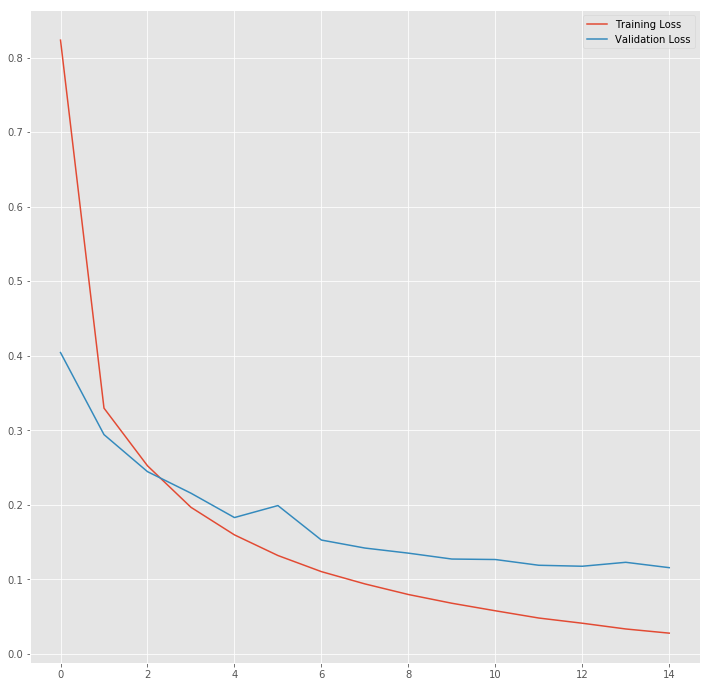

In [23]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

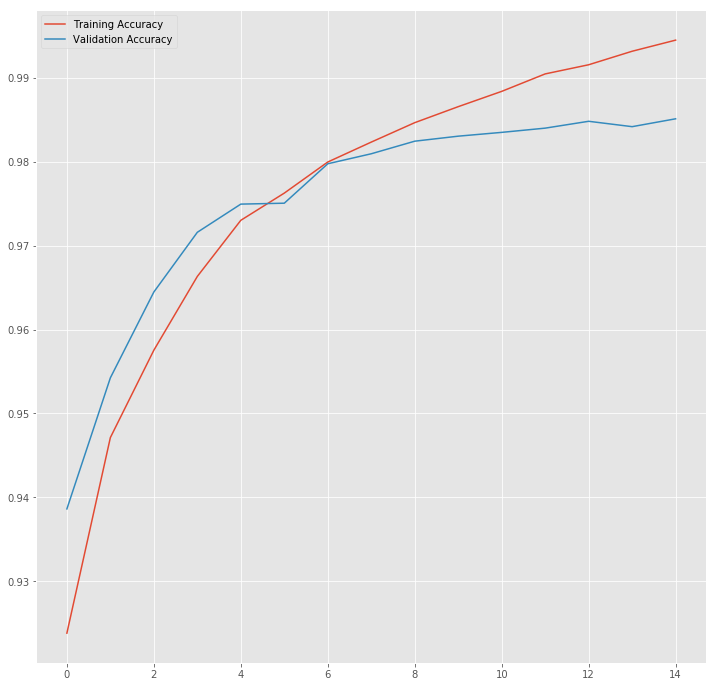

In [24]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te, X_pos_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = np.argmax(y_te[i], -1)
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
# print "\n"
print(report)

              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.00      0.00      0.00         1
1_GO:0000803       0.43      1.00      0.60         3
1_GO:0000805       0.89      1.00      0.94         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       1.00      1.00      1.00         9
1_GO:0001741       1.00      1.00      1.00        22
1_GO:0001750       0.88      0.96      0.92        24
1_GO:0001917       0.78      1.00      0.88         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.73      1.00      0.84         8
1_GO:0005635       0.00      0.00      0.00         0
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.00      0.00      0.00         2
1_GO:0005667       0.00      0.00      0.00         1
1_GO:0005675       0.50      1.00      0.67         2
1_GO:0005714       0.00    

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
# report_lines = report.splitlines()[2:]
# labels = []
# precision = []
# recall = []
# f1 = []
# support = []
# for line in report_lines:
#     data = line.split()
#     labels.append(data[0])
#     precision.append(float(data[1]))
#     recall.append(float(data[2]))
#     f1.append(float(data[3]))
#     support.append(float(data[4]))
#     if(data[0] == 'O'):
#         break

In [27]:
# precision_all_but_O = sum((np.array(precision[:-1]) * np.array(support[:-1])))/sum(support)
# recall_all_but_O = sum((np.array(recall[:-1]) * np.array(support[:-1])))/sum(support)
# f1_all_but_O = sum((np.array(f1[:-1]) * np.array(support[:-1])))/sum(support)

In [28]:
# print(precision_all_but_O)
# print(recall_all_but_O)
# print(f1_all_but_O)

In [29]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print(pred)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], np.argmax(y_te[i], -1), pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))
        
# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

[  0   0   0   0   0 173   0   0   0   0   0   0   0   0 164   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0  63   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
Word           ||True ||Pred
E-cad          : O     O
beaded         : O     O
Lifesciences   : O     O
S4             : O     O
alpha-actinin  : O     O
testis-specific: GO:0005634 GO:0005634
Mmp7           : O     O
PGC-1α−/−      : O     O
embryos        : O     O
Hyperproliferation: O     O
regeneration   : O     O
PBS/0.1        : O     O
alpha-actinin  : O     O
Lifesciences   : O     O
synapses       : O     GO:0005576
participating  : O     O
procedures     : O     O
DAPI-stained   : O     O
procedures     : O     O
THRB           : O     O
knowledge      : O     O
BioRad         : O     O
embryos        : O     O
vascularis     : O     O
screening      : O     O
phosphodiester

In [30]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [31]:
df = df[df['Word'] != 'O']

In [32]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]

report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print("\n")
print(report)



              precision    recall  f1-score   support

1_GO:0000790       0.00      0.00      0.00         1
1_GO:0000795       1.00      1.00      1.00         4
1_GO:0000800       0.00      0.00      0.00         1
1_GO:0000803       0.43      1.00      0.60         3
1_GO:0000805       0.89      1.00      0.94         8
1_GO:0000806       1.00      1.00      1.00         2
1_GO:0001739       1.00      1.00      1.00         9
1_GO:0001741       1.00      1.00      1.00        22
1_GO:0001750       0.88      0.96      0.92        24
1_GO:0001917       0.78      1.00      0.88         7
1_GO:0005615       0.00      0.00      0.00         1
1_GO:0005634       0.73      1.00      0.84         8
1_GO:0005635       0.00      0.00      0.00         0
1_GO:0005643       0.00      0.00      0.00         1
1_GO:0005657       0.00      0.00      0.00         2
1_GO:0005667       0.00      0.00      0.00         1
1_GO:0005675       0.50      1.00      0.67         2
1_GO:0005714       0.00  

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [190]:
# df.to_csv('../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv', sep='\t')

In [173]:
# !python ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 
#%run ./Go_Deep/src/accuracy/src/computeSim.py ../data/results/GO_merged_CHAR_LSTM_Based_CRF.tsv ../data/validation_data/GO_AllSubsumers.tsv 